Github repository: https://github.com/criss-bassu/ANN_tutorial

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load and prepare data
titanic = sns.load_dataset('titanic')
df = titanic[['pclass', 'sex', 'age', 'survived']].copy()

# Handle missing values in 'age' by grouping by 'pclass' and 'sex' and filling with the mean
df['age'] = df.groupby(['pclass', 'sex'])['age'].transform(lambda x: x.fillna(x.mean()))

# Convert sex to binary
df['sex'] = df['sex'].map({'female': 0, 'male': 1})

# Separate the inputs from the output
X = df[['pclass', 'sex', 'age']]
y = df['survived']

# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Normalize age using Z-score
age_mean = X_train['age'].mean()
age_std = X_train['age'].std()
X_train['age'] = (X_train['age'] - age_mean) / age_std
X_test['age'] = (X_test['age'] - age_mean) / age_std

# Normalize pclass using Z-score
pclass_mean = X_train['pclass'].mean()
pclass_std = X_train['pclass'].std()
X_train['pclass'] = (X_train['pclass'] - pclass_mean) / pclass_std
X_test['pclass'] = (X_test['pclass'] - pclass_mean) / pclass_std

# Build model
# We use a Sequestional model in order to stacks the layers linearly
# We use Dense layers to make sure that every neuron in one layer is connected to every neuron in the next layer
model = Sequential([                                    # Input layer: 3 units (pclass, age, sex)
    Dense(10, activation = 'relu', input_shape = (3,)), # Hidden layer: 10 units
    Dense(1, activation = 'sigmoid')                    # Output layer: 1 unit (survived)
])

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', # Binary classification problem
              metrics = ['accuracy'])       # Measure and display accuracy after each training epoch

# Train model
model.fit(X_train, y_train,
          epochs = 100,           # Number of times the model sees the entire training dataset
          batch_size = 32,        # Size of each mini-batch during gradient descent steps
          validation_split = 0.2, # 20% of training data for validation
          verbose = 0)            # Suppress training output

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test accuracy: {test_acc:.2f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test accuracy: 0.82


The model has correctly predicted the outcome for 82% of the samples in the test dataset. Because of this, we can conclude that the model has learned to generalize reasonably well from the training data. However, there may still be room for improvement.

Next, we are going to check how many actual negatives and positives were predicted correctly and wrongly using a confusion matrix.

In [ ]:
# Confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred > 0.5)
cm = pd.DataFrame(cm, index = ['Actual Negative', 'Actual Positive'], columns = ['Predicted Negative', 'Predicted Positive'])
print('Confusion Matrix:')
print(cm)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 140                  17
Actual Positive                  32                  79


Lastly, we created a ROC curve to evaluate the performance of our classification model, since it helps us understand the relationship between the sensitivity (true positive rate - proportion of actual positives that are correctly identified) and the specifity (false positive rate - proportion of actual negatives that are correctly identified as negative).

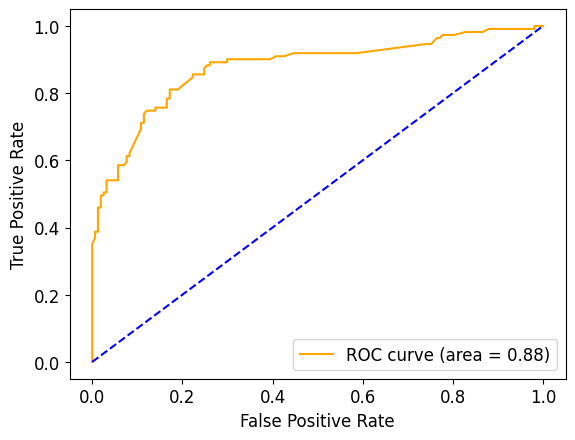

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'orange', label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'blue', linestyle = '--')
plt.xlabel('False Positive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.legend(loc = "lower right", fontsize = 12)
plt.show()

The higher and to the left the ROC curve is, the better the model is. Since it is over the diagonal, our model has a good performance.

Note that the dashed blue diagonal represents a model which classifies randomly.